In [1]:
from function import count_most_used_char
import pandas as pd

In [2]:
df = pd.read_csv("./alpha_beta.csv")
len(df)

2541

In [3]:
import time
from functools import wraps

def time_function(times: int = 1):
    def decorate(fn):
        @wraps(fn)
        def inner():
            tic = time.perf_counter()
            for _ in range(times):
                fn()
            toc = time.perf_counter()
            
            full = toc - tic
            print(f"Function took {full:0.4f} seconds")
            return toc - tic
    
        return inner
    return decorate

times_save = {}

In [4]:
@time_function(10)
def hello():
    time.sleep(0.01)
    
hello()

Function took 0.1011 seconds


0.101059135999094

In [5]:
@time_function(10)
def unoptimized():
    count = []
    for seq in df.Sequence:
        c = count_most_used_char(seq)
        count.append(c)
            
unoptimized_time = unoptimized()
times_save["unoptimized_time"] = unoptimized_time
unoptimized_time

Function took 4.5478 seconds


4.5478363479996915

In [6]:
@time_function(10)
def using_map():
    count = list(map(count_most_used_char, df.Sequence))
        
using_map_time = using_map()
times_save["using_map_time"] = using_map_time
using_map_time

Function took 4.6689 seconds


4.668885297000088

In [7]:
import multiprocessing.dummy

@time_function(10)
def using_proc_map():
    p = multiprocessing.dummy.Pool(8)
    count = list(p.map(count_most_used_char, df.Sequence))
    
using_proc_map_time = using_proc_map()
times_save["using_proc_map_time"] = using_proc_map_time
using_proc_map_time

Function took 4.4465 seconds


4.4464834190002875

In [8]:
import threading

def thread_target(start, end):
    return list(map(count_most_used_char, df.Sequence.iloc[start:end]))
    
@time_function(10)
def using_threads():
    n = len(df.Sequence)
    i = n // 4
    
    start = 0
    end = i
    
    threads = []
    
    for thread in range(4):                
        start += i
        end += i
        
        x = threading.Thread(target=thread_target, args=(start, end,))
        threads.append(x)
        x.start()
        
    for thread in threads:
        thread.join()

        
    return i

using_threads_time = using_threads()
times_save["using_threads_time"] = using_threads_time
using_threads_time

Function took 3.3823 seconds


3.382301150000785

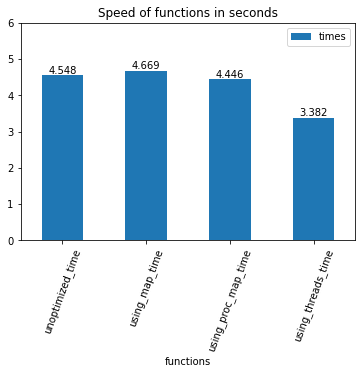

In [28]:
times_df = pd.DataFrame({"functions": times_save.keys(), "times": [round(x, 3) for x in times_save.values()]})
import matplotlib.pyplot as plt

def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha="center", va="bottom")

times_df.plot.bar(x="functions", y="times", rot=70, title="Speed of functions in seconds");
add_labels(list(times_df["functions"]), list(times_df["times"]))
plt.ylim(0, 6)
plt.savefig("out.png", facecolor="#fff")
plt.show();